In [1]:
import sklearn
sklearn.__version__

'0.24.1'

## Data preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import silhouette_score
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import json
from api_keys import *

In [3]:
moosic = pd.read_csv("../data/big_df_audio_features.csv")
moosic.drop_duplicates(subset='name', inplace=True)
moosic.set_index(["name", "artist"], inplace=True)

In [4]:
#moosic.info()
moosic.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
dtype: object

In [5]:
moosic.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

In [6]:
moosic.drop(columns=["duration_ms", "key", "time_signature", "loudness", 'mode', "speechiness", "liveness"], inplace=True)

In [7]:
moosic.head(3)

,,danceability,energy,acousticness,instrumentalness,valence,tempo
name,artist,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.658,0.259,0.694,0.000059,0.306,110.376
Saudade De Bahia,Antônio Carlos Jobim,0.742,0.399,0.217,0.000002,0.693,125.039
"Canta Canta, Minha Gente",Martinho Da Vila,0.851,0.730,0.453,0.000063,0.905,93.698


In [8]:
columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence', 'tempo']

moosic_sample = moosic.filter(columns)

## Modelling

### MinMaxScaler

In [9]:
minmax = MinMaxScaler(feature_range=(0,1))
minmax.fit(moosic_sample)
minmax_scaled = minmax.transform(moosic_sample)
minmax_scaled = pd.DataFrame(minmax_scaled, columns = moosic_sample.columns, index = moosic_sample.index)
minmax_scaled.head(3)

,,danceability,energy,acousticness,instrumentalness,valence,tempo
name,artist,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.680455,0.259,0.696787,0.000060,0.310660,0.515800
Saudade De Bahia,Antônio Carlos Jobim,0.767322,0.399,0.217871,0.000002,0.703553,0.584322
"Canta Canta, Minha Gente",Martinho Da Vila,0.880041,0.730,0.454819,0.000064,0.918782,0.437862


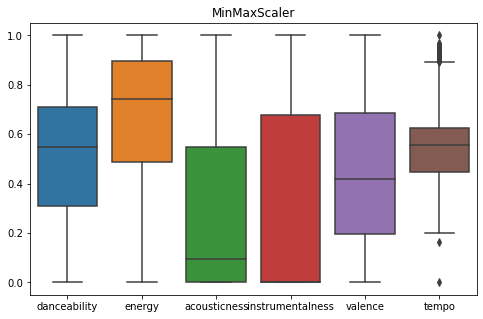

In [10]:
plt.subplots(figsize=(8, 5))
sns.boxplot(data=minmax_scaled.loc[:, moosic.columns])
plt.title('MinMaxScaler')
plt.show()

### QuantileTransformer

In [11]:
qtl_transformer = QuantileTransformer(n_quantiles=10, random_state=0)
qtl_scaled = qtl_transformer .fit_transform(moosic)
qtl_scaled = pd.DataFrame(qtl_scaled, columns = moosic.columns, index = moosic.index)
qtl_scaled.head(3)

,,danceability,energy,acousticness,instrumentalness,valence,tempo
name,artist,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.702020,0.144318,0.800508,0.343393,0.380952,0.411439
Saudade De Bahia,Antônio Carlos Jobim,0.836074,0.203167,0.604861,0.235875,0.762667,0.605786
"Canta Canta, Minha Gente",Martinho Da Vila,0.932045,0.484225,0.716413,0.344482,0.942280,0.209747


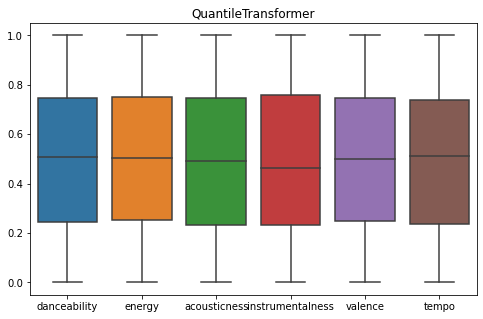

In [12]:
plt.subplots(figsize=(8, 5))
sns.boxplot(data=qtl_scaled.loc[:, moosic.columns])
plt.title('QuantileTransformer')
plt.show()

In [13]:
from sklearn.cluster import KMeans
moosic_kmeans = KMeans(n_clusters=13, random_state = 123).fit(qtl_scaled)

In [14]:
centroids = pd.DataFrame(moosic_kmeans.cluster_centers_)
centroids.columns = columns

#### Using inertia

In [15]:
moosic_kmeans.inertia_

598.9408203032694

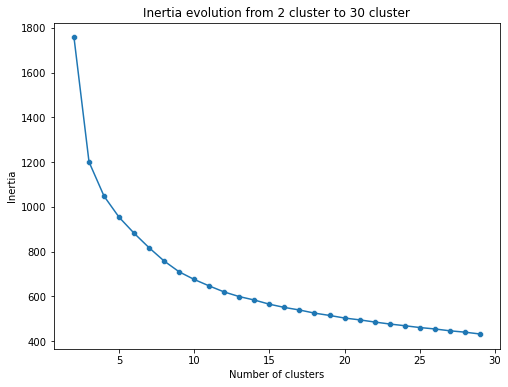

In [16]:
inertia = []

for i in range(2, 30): 
    inertia.append(KMeans(n_clusters=i, random_state = 123).fit(qtl_scaled).inertia_)

fig, ax = plt.subplots(figsize=(8, 6))
plt.title(f'Inertia evolution from 2 cluster to 30 cluster')
sns.lineplot(x=range(2, 30), y=inertia)
sns.scatterplot(x=range(2, 30), y=inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Silhouette Score

In [17]:
silhouette_score(qtl_scaled, moosic_kmeans.labels_)

0.2304603732856943

The score of 0 means that clusters are overlapping. Close to 1 means clusters are well apart from each other and clearly distinguished. Close - 1 means that data belonging to clusters may be wrong/incorrect.

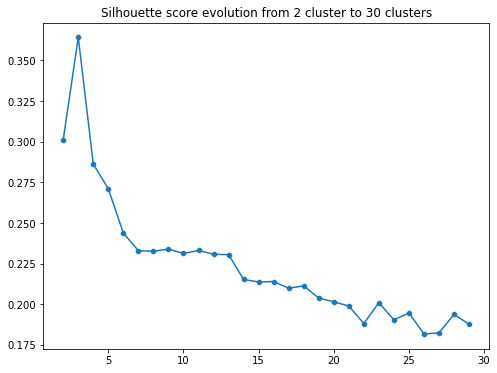

In [20]:
sil_score = []

for i in range(2, 30): 
    labels = KMeans(n_clusters=i, random_state = 123).fit(qtl_scaled).labels_
    sil_score.append(silhouette_score(qtl_scaled, labels))

fig, ax = plt.subplots(figsize=(8, 6))
plt.title(f'Silhouette score evolution from 2 cluster to 30 clusters')
sns.lineplot(x=range(2, 30), y=sil_score)
sns.scatterplot(x=range(2, 30), y=sil_score)
plt.show()

In [19]:
# Check highest silhouette_score given number of clusters in range (2, 100)

list_of_silouetthes = {'number':[],'score':[]}
for i in range(2,100):
    
    moosic_kmeans = KMeans(n_clusters=i).fit(qtl_scaled)
    list_of_silouetthes['score'].append(silhouette_score(qtl_scaled, moosic_kmeans.labels_))
    list_of_silouetthes['number'].append(i)


    
sil = pd.DataFrame.from_dict(list_of_silouetthes)
sil

,number,score
0,2,0.301297
1,3,0.364155
2,4,0.286173
3,5,0.270998
4,6,0.243736
...,...,...
93,95,0.168326
94,96,0.167140
95,97,0.168794
96,98,0.168585


In [20]:
sil.score.max()

0.3641548143219915

In [21]:
from sklearn.cluster import KMeans
moosic_kmeans = KMeans(n_clusters=13, random_state=123).fit(qtl_scaled)

In [22]:
centroids = pd.DataFrame(moosic_kmeans.cluster_centers_)
centroids.columns = columns
centroids

,danceability,energy,acousticness,instrumentalness,valence,tempo
0,0.186411,0.819824,0.108410,0.742116,0.270638,0.801272
1,0.820352,0.494849,0.529561,0.393979,0.801061,0.316381
2,0.285806,0.089146,0.921531,0.820878,0.216508,0.736710
3,0.561517,0.662498,0.383886,0.073115,0.570334,0.694745
4,0.631986,0.618960,0.308122,0.546101,0.324423,0.623965
5,0.205419,0.070649,0.934630,0.820707,0.154028,0.152619
6,0.807640,0.485193,0.548995,0.002621,0.740179,0.277307
7,0.716008,0.422638,0.626496,0.102527,0.844152,0.772548
8,0.488124,0.292609,0.667835,0.145795,0.426445,0.782817
9,0.493476,0.263417,0.707216,0.169504,0.455152,0.222349


In [23]:
clusters = moosic_kmeans.predict(qtl_scaled)

In [24]:
qtl_scaled["cluster"] = clusters
test_sample = qtl_scaled.groupby('cluster').sample(5)

In [25]:
centroid_dis = pd.DataFrame(data=moosic_kmeans.cluster_centers_, columns= qtl_scaled.drop("cluster", axis=1).columns)

In [26]:
qtl_scaled['cluster'] = moosic_kmeans.labels_

In [27]:
cluster_0_songs = qtl_scaled.query('cluster == 0')

In [28]:
cluster_0_songs = cluster_0_songs.assign(distance = 0)

In [29]:
# Create a list of the playlists. Iterate 13 times, get through all clusters and get the distance between all clusters and data points and output 20 songs with the smallest values. 

list_of_playlists= []
for i in range(13):
    list_of_playlists.append(qtl_scaled.query('cluster == @i'))
    list_of_playlists[i] = list_of_playlists[i].assign(distance=0)
    for j, song in list_of_playlists[i].iterrows():
        total = sum(((song.iloc[pos]- centroid_dis.iloc[1][pos])**2) for pos in range(qtl_scaled.shape[1]-3))**(1/2)
        list_of_playlists[i].loc[j,'distance'] = total
    list_of_playlists[i] = list_of_playlists[i].sort_values('distance').head(30)
    list_of_playlists[i] = list_of_playlists[i].reset_index()

In [30]:
scope = 'playlist-modify-public'
username = spotify_username
#redirectUri = 'http://localhost:8888/callback'

token = SpotifyOAuth(scope=scope, username=spotify_username, client_id=spotify_client_id, client_secret=spotify_client_secret, redirect_uri='http://localhost:8000/callback')
spotifyObject = spotipy.Spotify(auth_manager = token)

In [31]:
for i, playlist in enumerate(list_of_playlists):
    playlist_name = f'Playlist_cluster_{i}'
    playlist_description= ''
    playlist_id = spotifyObject.user_playlist_create(user=spotify_username ,name=playlist_name,public=True,description=playlist_description)['id']
    list_of_songs = []
    for index, song in playlist.iterrows():
        result = spotifyObject.search(q=f"{song['name']} artist:{song['artist']}",type='track',limit=1)
        try:
            list_of_songs.append(result['tracks']['items'][0]['uri'])
        except:
            continue
    spotifyObject.user_playlist_add_tracks(user=spotify_username, playlist_id=playlist_id, tracks=list_of_songs)

In [ ]:
#Calculate the distance between the centroids and data points

# for i, song in cluster_0_songs.iterrows():
#     total = sum(((song.iloc[pos]- centroid_dis.iloc[1][pos])**2) for pos in range(qtl_scaled.shape[1]-3))**(1/2)
#     cluster_0_songs.loc[i,'distance'] = total

# playlist_0 = cluster_0_songs.sort_values('distance').reset_index().head(30)
# playlist_0

In [27]:
# playlist_name = 'playlist_cluster_0'
# playlist_description= ''
# playlist_id = spotifyObject.user_playlist_create(user=spotify_username, name=playlist_name, public=True, description=playlist_description)['id']
# list_of_songs = []
# for index, song in playlist_0.iterrows():
#     result = spotifyObject.search(q=f"{song['name']} artist:{song['artist']}",type='track',limit=1)
#     try:
#         list_of_songs.append(result['tracks']['items'][0]['uri'])
#     except:
#         continue
        
# spotifyObject.user_playlist_add_tracks(user=spotify_username, playlist_id=playlist_id, tracks=list_of_songs)

In [35]:
# Assign a label column
qtl_scaled['label'] = qtl_scaled.cluster

<ipython-input-39-01e87417502d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qtl_scaled.label[qtl_scaled.label==1] = 'POP'
<ipython-input-39-01e87417502d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qtl_scaled.label[qtl_scaled.label==10] = 'Death Metal'


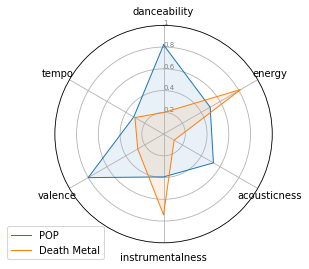

In [39]:
from math import pi

# Assign labels
qtl_scaled.label[qtl_scaled.label==1] = 'POP'
qtl_scaled.label[qtl_scaled.label==10] = 'Death Metal'

# Find centroids
cluster_positions = qtl_scaled.drop(['label'], axis=1).groupby(by="cluster").mean() 
cluster_positions

# ------- PART 1: Create background

# number of variables
categories = cluster_positions.columns.values.tolist()
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.2,0.4,0.6,0.8,1], ["0.2","0.4","0.6","0.8","1"], color="grey", size=7)
plt.ylim(0,1)

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
 

# First genre
label_1 = 'POP'
label_cluster_1 = qtl_scaled[qtl_scaled.label==label_1].iloc[0].cluster

values=cluster_positions.loc[label_cluster_1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"{label_1}")
ax.fill(angles, values, alpha=0.1)

# Second genre
label_2 = 'Death Metal'
label_cluster_2 = qtl_scaled[qtl_scaled.label==label_2].iloc[0].cluster

values=cluster_positions.loc[label_cluster_2].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"{label_2}")
ax.fill(angles, values, alpha=0.1)
 
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.25, 0.1))

# Show the graph
plt.show()

In [40]:
plt.savefig('Metal_vs_classical')

<Figure size 432x288 with 0 Axes>